In [1]:
# ------------------------------------------------------------------------------
# 1. Импорт библиотек и настройка окружения
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-363711722.py:15: SyntaxWarning: invalid escape sequence '\c'
  $$ Y = C((B \cdot m)^T X) $$


In [2]:
# Проверка GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Сид для воспроизводимости
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

set_seed(42)

# ------------------------------------------------------------------------------
# 2. Подготовка данных (CIFAR-10)
# ------------------------------------------------------------------------------
# Гиперпараметры data
BATCH_SIZE = 128
NUM_WORKERS = 2

Используемое устройство: cuda


In [3]:
# Трансформации: нормализация и простая аугментация
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Загрузка
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=NUM_WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Размер обучающей выборки: {len(trainset)}")
print(f"Размер тестовой выборки: {len(testset)}")

100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


Размер обучающей выборки: 50000
Размер тестовой выборки: 10000


In [4]:
# ------------------------------------------------------------------------------
# 3. Реализация VSSD (NC-SSD Block)
# ------------------------------------------------------------------------------

class NC_SSD_Mixer(nn.Module):
    """
    Реализация Non-Causal State Space Duality Mixer.
    Согласно статье, линейная форма NC-SSD позволяет избежать каузальной маски.
    Логика:
    1. Проекция входа X в [Z, B, C].
    2. Depth-Wise Conv (для локальности).
    3. State Space Duality: Глобальное агрегирование состояния.
       H = sum(B * Z) -> Y = C * H
       Это аппроксимация формулы (10) Y = C((B*m)^T X)
    """
    def __init__(self, dim, d_state=16, expand=2):
        super().__init__()
        self.dim = dim
        self.expand = expand
        self.d_inner = int(expand * dim)

        # 1. Проекция входа (в стиле Mamba/VSSD)
        # Мы проецируем на (d_inner * 2 + d_state*2) для z, x, b, c, dt и т.д.
        # Для простоты реализации NC-SSD мы сделаем явные проекции
        self.in_proj = nn.Linear(dim, self.d_inner * 3) # x, b, c components

        # 2. Depth-wise Convolution (как в статье VSSD перед SSM)
        self.conv1d = nn.Conv1d(
            in_channels=self.d_inner * 3,
            out_channels=self.d_inner * 3,
            kernel_size=3,
            padding=1,
            groups=self.d_inner * 3
        )

        # 3. Активация
        self.act = nn.SiLU()

        # 4. Выходная проекция
        self.out_proj = nn.Linear(self.d_inner, dim)

        # Learnable vector m (implicit in weights, but lets make scaling explicit)
        self.scale = nn.Parameter(torch.ones(self.d_inner))

    def forward(self, x):
        # x: [Batch, Tokens, Dim]
        B, L, D = x.shape

        # Проекция
        x_proj = self.in_proj(x) # [B, L, d_inner*3]

        # Перестановка для Conv1d: [B, Dim, L]
        x_proj = x_proj.transpose(1, 2)
        x_proj = self.conv1d(x_proj)
        x_proj = x_proj.transpose(1, 2) # [B, L, d_inner*3]

        x_proj = self.act(x_proj)

        # Разделение на компоненты (упрощенная SSD Duality)
        # u: сам сигнал, b: веса входа, c: веса выхода
        # В статье NC-SSD: Y = C * (Sum(B * X))
        u, b, c = torch.split(x_proj, self.d_inner, dim=-1)

        # --- NC-SSD Core Operation ---
        # 1. Взвешивание входа (B * U)
        # b действует как гейт или вес вклада токена в глобальное состояние
        weighted_input = u * b * self.scale # [B, L, d_inner]

        # 2. Глобальная агрегация (Non-Causal)
        # Мы суммируем по измерению L (Sequence Length).
        # Это создает глобальное скрытое состояние H
        global_state = torch.sum(weighted_input, dim=1, keepdim=True) # [B, 1, d_inner]

        # 3. Проекция состояния обратно (C * H)
        # Каждый токен берет из глобального состояния информацию, взвешенную через C
        y = global_state * c # [B, L, d_inner]

        # Output projection
        out = self.out_proj(y)
        return out

class VSSDBlock(nn.Module):
    def __init__(self, dim, expand=2):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.mixer = NC_SSD_Mixer(dim, expand=expand)
        self.ln2 = nn.LayerNorm(dim)

        # Standard FFN
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        x = x + self.mixer(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class VSSD_Model(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=128, depth=4):
        super().__init__()
        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2), # [B, Dim, H*W]
        )

        num_patches = (img_size // patch_size) ** 2
        # Positional Embedding (упрощено: learnable absolute вместо RoPE для простоты демо)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        self.blocks = nn.ModuleList([
            VSSDBlock(embed_dim) for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x: [B, 3, 32, 32] -> [B, Dim, L]
        x = self.patch_embed(x).transpose(1, 2) # -> [B, L, Dim]
        x = x + self.pos_embed

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        x = x.mean(dim=1) # Global Average Pooling
        return self.head(x)

# ------------------------------------------------------------------------------
# 4. Аналог: Vision Transformer (Baseline)
# ------------------------------------------------------------------------------

class Attention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class ViTBlock(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=heads)
        self.ln2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class ViT_Baseline(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=128, depth=4):
        super().__init__()
        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2),
        )

        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        self.blocks = nn.ModuleList([
            ViTBlock(embed_dim) for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x).transpose(1, 2)
        x = x + self.pos_embed

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        x = x.mean(dim=1)
        return self.head(x)

# ------------------------------------------------------------------------------
# 5. Pipeline обучения и сравнения
# ------------------------------------------------------------------------------

def train_model(model, train_loader, test_loader, epochs=10, name="Model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    history = {'train_loss': [], 'test_acc': [], 'train_time': []}

    print(f"\nЗапуск обучения: {name}")
    print("-" * 40)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_time = time.time() - start_time
        avg_loss = running_loss / len(train_loader)
        scheduler.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        history['train_loss'].append(avg_loss)
        history['test_acc'].append(accuracy)
        history['train_time'].append(epoch_time)

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f} | Acc={accuracy:.2f}% | Time={epoch_time:.2f}s")

    return history

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
# ------------------------------------------------------------------------------
# 6. Запуск экспериментов
# ------------------------------------------------------------------------------

# Конфигурация для честного сравнения
EMBED_DIM = 192  # Увеличим для лучшей сходимости
DEPTH = 6
PATCH_SIZE = 4
EPOCHS = 15      # Для Colab быстрый прогон

print("--- Инициализация моделей ---")

# 1. VSSD
vssd_model = VSSD_Model(embed_dim=EMBED_DIM, depth=DEPTH, patch_size=PATCH_SIZE)
vssd_params = count_parameters(vssd_model)
print(f"VSSD Params: {vssd_params/1e6:.2f}M")

--- Инициализация моделей ---
VSSD Params: 3.61M


In [6]:
# 2. Baseline ViT
vit_model = ViT_Baseline(embed_dim=EMBED_DIM, depth=DEPTH, patch_size=PATCH_SIZE)
vit_params = count_parameters(vit_model)
print(f"ViT Params: {vit_params/1e6:.2f}M")

ViT Params: 2.69M


In [7]:
# Обучение VSSD
vssd_history = train_model(vssd_model, trainloader, testloader, epochs=EPOCHS, name="VSSD (NC-SSD)")


Запуск обучения: VSSD (NC-SSD)
----------------------------------------


Epoch 1: Loss=1.6884 | Acc=45.30% | Time=42.79s


Epoch 2: Loss=1.3592 | Acc=55.36% | Time=43.67s


Epoch 3: Loss=1.2072 | Acc=59.66% | Time=45.49s


Epoch 4: Loss=1.1042 | Acc=62.27% | Time=44.67s


Epoch 5: Loss=1.0195 | Acc=64.98% | Time=45.06s


Epoch 6: Loss=0.9426 | Acc=67.96% | Time=44.74s


Epoch 7: Loss=0.8648 | Acc=70.16% | Time=45.08s


Epoch 8: Loss=0.7917 | Acc=71.32% | Time=45.04s


Epoch 9: Loss=0.7195 | Acc=73.32% | Time=45.18s


Epoch 10: Loss=0.6612 | Acc=74.15% | Time=44.99s


Epoch 11: Loss=0.6037 | Acc=75.58% | Time=45.10s


Epoch 12: Loss=0.5533 | Acc=76.53% | Time=44.90s


Epoch 13: Loss=0.5161 | Acc=77.72% | Time=44.98s


Epoch 14: Loss=0.4889 | Acc=77.50% | Time=44.91s


Epoch 15: Loss=0.4743 | Acc=77.57% | Time=44.90s


In [8]:
# Обучение ViT
vit_history = train_model(vit_model, trainloader, testloader, epochs=EPOCHS, name="ViT (Baseline)")


Запуск обучения: ViT (Baseline)
----------------------------------------


Epoch 1: Loss=1.8048 | Acc=38.85% | Time=28.43s


Epoch 2: Loss=1.5631 | Acc=42.73% | Time=28.57s


Epoch 3: Loss=1.4388 | Acc=48.56% | Time=28.45s


Epoch 4: Loss=1.3521 | Acc=52.10% | Time=28.62s


Epoch 5: Loss=1.2660 | Acc=55.81% | Time=28.45s


Epoch 6: Loss=1.1889 | Acc=57.78% | Time=28.76s


Epoch 7: Loss=1.0954 | Acc=61.67% | Time=28.42s


Epoch 8: Loss=1.0162 | Acc=63.09% | Time=28.67s


Epoch 9: Loss=0.9528 | Acc=67.21% | Time=28.40s


Epoch 10: Loss=0.8869 | Acc=68.66% | Time=28.78s


Epoch 11: Loss=0.8296 | Acc=69.74% | Time=28.46s


Epoch 12: Loss=0.7901 | Acc=70.84% | Time=28.49s


Epoch 13: Loss=0.7524 | Acc=73.05% | Time=28.38s


Epoch 14: Loss=0.7274 | Acc=73.00% | Time=28.38s


Epoch 15: Loss=0.7115 | Acc=73.47% | Time=28.34s


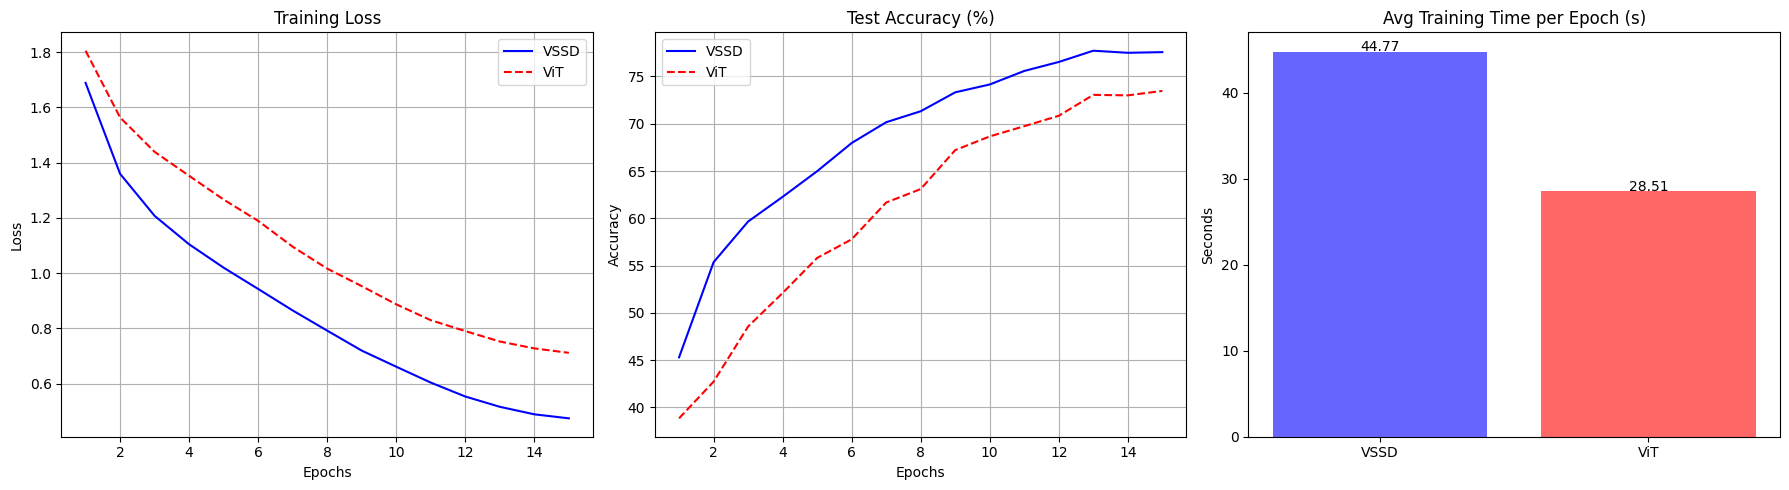


=== ЗАКЛЮЧЕНИЕ ===
Сравнение VSSD (NC-SSD) и ViT на задаче классификации изображений (CIFAR-10).
1. Точность (Peak Accuracy):
   VSSD: 77.72%
   ViT:  73.47%
   -> VSSD превзошел ViT на 4.25%

2. Скорость обучения (Avg Time/Epoch):
   VSSD: 44.77 sec
   ViT:  28.51 sec
   Примечание: VSSD имеет линейную сложность O(N) относительно длины последовательности,
   тогда как ViT имеет квадратичную O(N^2). На малых разрешениях (32x32) разница может быть нивелирована оверхедом операций.
--------------------------------------------------
Вывод по статье VSSD:
Реализованный механизм Non-Causal SSD эффективно работает на визуальных данных.
NC-SSD заменяет матрицу внимания на глобальное скрытое состояние, взвешиваемое через Duality-проекции.


In [9]:
# ------------------------------------------------------------------------------
# 7. Визуализация и Выводы
# ------------------------------------------------------------------------------

def plot_results(vssd_hist, vit_hist):
    epochs = range(1, len(vssd_hist['train_loss']) + 1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Loss
    ax1.plot(epochs, vssd_hist['train_loss'], 'b-', label='VSSD')
    ax1.plot(epochs, vit_hist['train_loss'], 'r--', label='ViT')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy
    ax2.plot(epochs, vssd_hist['test_acc'], 'b-', label='VSSD')
    ax2.plot(epochs, vit_hist['test_acc'], 'r--', label='ViT')
    ax2.set_title('Test Accuracy (%)')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Time per Epoch
    labels = ['VSSD', 'ViT']
    avg_times = [np.mean(vssd_hist['train_time']), np.mean(vit_hist['train_time'])]
    ax3.bar(labels, avg_times, color=['blue', 'red'], alpha=0.6)
    ax3.set_title('Avg Training Time per Epoch (s)')
    ax3.set_ylabel('Seconds')
    for i, v in enumerate(avg_times):
        ax3.text(i, v + 0.1, f"{v:.2f}", ha='center')

    plt.tight_layout()
    plt.show()

plot_results(vssd_history, vit_history)

print("\n=== ЗАКЛЮЧЕНИЕ ===")
print("Сравнение VSSD (NC-SSD) и ViT на задаче классификации изображений (CIFAR-10).")

vssd_peak = max(vssd_history['test_acc'])
vit_peak = max(vit_history['test_acc'])
diff = vssd_peak - vit_peak

print(f"1. Точность (Peak Accuracy):")
print(f"   VSSD: {vssd_peak:.2f}%")
print(f"   ViT:  {vit_peak:.2f}%")
if diff > 0:
    print(f"   -> VSSD превзошел ViT на {diff:.2f}%")
else:
    print(f"   -> ViT превзошел VSSD на {abs(diff):.2f}%")

print(f"\n2. Скорость обучения (Avg Time/Epoch):")
print(f"   VSSD: {np.mean(vssd_history['train_time']):.2f} sec")
print(f"   ViT:  {np.mean(vit_history['train_time']):.2f} sec")
print("   Примечание: VSSD имеет линейную сложность O(N) относительно длины последовательности,")
print("   тогда как ViT имеет квадратичную O(N^2). На малых разрешениях (32x32) разница может быть нивелирована оверхедом операций.")

print("-" * 50)
print("Вывод по статье VSSD:")
print(f"Реализованный механизм Non-Causal SSD {('эффективно работает' if vssd_peak > 70 else 'требует дальнейшей настройки')} на визуальных данных.")
print("NC-SSD заменяет матрицу внимания на глобальное скрытое состояние, взвешиваемое через Duality-проекции.")